### Grab the dataset from kaggle using API
* mount the goole drive
* load the kaggle credentials into colab 
* download the dataset from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
GDRIVE = "/content/drive/MyDrive/CapstoneAIML/"

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/CapstoneAIML/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#https://www.kaggle.com/questions-and-answers/165032#1327573
from kaggle.api.kaggle_api_extended import KaggleApi
DS_PATH = "/content/dataset"
COMPETITION = "rsna-pneumonia-detection-challenge"
api = KaggleApi()
api.authenticate()
api.competition_download_files(COMPETITION, DS_PATH)

In [ ]:
!  unzip -oq /content/dataset/rsna-pneumonia-detection-challenge.zip -d /content/dataset

In [ ]:
!ls -l /content/dataset

total 3845432
-rw-r--r-- 1 root root         55 Dec 11  2019 'GCP Credits Request Link - RSNA.txt'
-rw-r--r-- 1 root root 3932287530 Mar 24 12:19  rsna-pneumonia-detection-challenge.zip
-rw-r--r-- 1 root root    1647396 Dec 11  2019  stage_2_detailed_class_info.csv
-rw-r--r-- 1 root root     159027 Dec 11  2019  stage_2_sample_submission.csv
drwxr-xr-x 2 root root     221184 Mar 24 12:19  stage_2_test_images
drwxr-xr-x 2 root root    1900544 Mar 24 12:19  stage_2_train_images
-rw-r--r-- 1 root root    1490034 Dec 11  2019  stage_2_train_labels.csv


### Necessary library imports 

In [ ]:
import os
import shutil
import time
import datetime

import pandas as pd
import numpy as np

import scipy.stats as stats

#%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns

! pip install pydicom
import pydicom as dcm

from glob import glob

from tqdm import tqdm, notebook

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.layers import Flatten, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Concatenate, ReLU, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from skimage.transform import resize

2.8.0
     |████████████████████████████████| 2.0 MB 5.1 MB/s 


### Exploring stage_2_train_labels.csv

In [ ]:
train_labels = pd.read_csv(DS_PATH+'/stage_2_train_labels.csv')
train_labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [ ]:
print('The train_labels dataframe has {} rows and {} columns.'.format(train_labels.shape[0], train_labels.shape[1]))
total_no_train_records = train_labels.shape[0]

The train_labels dataframe has 30227 rows and 6 columns.


In [ ]:
print('Number of unique patientId are: {}'.format(train_labels['patientId'].nunique()))

Number of unique patientId are: 26684


In [ ]:
train_labels_boxes = train_labels[train_labels['Target'] == 1].groupby('patientId').size().to_frame('number_of_box').reset_index()
train_labels = train_labels.merge(train_labels_boxes, on = 'patientId', how = 'left')
train_labels.head(10)

,patientId,x,y,width,height,Target,number_of_box
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,NaN
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,NaN
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,NaN
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2.0
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,2.0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,NaN
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,NaN
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,2.0
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,2.0


### Exploring stage_2_detailed_class_info.csv

In [ ]:
class_labels = pd.read_csv(DS_PATH+"/stage_2_detailed_class_info.csv")
class_labels.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [ ]:
print('The class_label dataframe has {} rows and {} columns.'.format(class_labels.shape[0], class_labels.shape[1]))

The class_label dataframe has 30227 rows and 2 columns.


In [ ]:
print('Number of unique patientId are: {}'.format(class_labels['patientId'].nunique()))

Number of unique patientId are: 26684


### Merge both the dataset

In [ ]:
train_labels_updated = train_labels.merge(class_labels, on = 'patientId', how = 'left')
train_labels_updated.head(10)

,patientId,x,y,width,height,Target,number_of_box,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,NaN,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2.0,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2.0,Lung Opacity
6,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,2.0,Lung Opacity
7,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,2.0,Lung Opacity
8,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal


In [ ]:
print('After merge, the dataset has {} rows and {} columns.'.format(train_labels_updated.shape[0], train_labels_updated.shape[1]))
print('After merge, the number of unique patientId are: {}.'.format(train_labels_updated['patientId'].nunique()))

After merge, the dataset has 37629 rows and 8 columns.
After merge, the number of unique patientId are: 26684.


### DICOM files and medical images

In [ ]:
print('Number of images in training images folders are: {}.'.format(len(os.listdir(DS_PATH+'/stage_2_train_images'))))

Number of images in training images folders are: 26684.


In [ ]:
training_image_path = DS_PATH+'/stage_2_train_images/'

images = pd.DataFrame({'path': glob(os.path.join(training_image_path, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x:os.path.splitext(os.path.basename(x))[0])
print('Columns in the training images dataframe: {}'.format(list(images.columns)))

Columns in the training images dataframe: ['path', 'patientId']


In [ ]:
# Merging the images dataframe with training_data dataframe
training_data = train_labels_updated.merge(images, on = 'patientId', how = 'left')
print('After merging the two dataframe, the training_data has {} rows and {} columns.'.format(training_data.shape[0], training_data.shape[1]))

After merging the two dataframe, the training_data has 37629 rows and 9 columns.


In [ ]:
print('The training_data dataframe as of now stands like\n')
training_data.head()

The training_data dataframe as of now stands like



,patientId,x,y,width,height,Target,number_of_box,class,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal,/content/dataset/stage_2_train_images/0004cfab...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal,/content/dataset/stage_2_train_images/00313ee0...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal,/content/dataset/stage_2_train_images/00322d4d...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,NaN,Normal,/content/dataset/stage_2_train_images/003d8fa0...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2.0,Lung Opacity,/content/dataset/stage_2_train_images/00436515...


### DenseNet201 Model build, train & test

In [ ]:
SAMPLE_DATA = training_data.shape[0]
GDRIVE_IMG_PATH = GDRIVE +"data" + ("" if SAMPLE_DATA == training_data.shape[0] else "_"+str(SAMPLE_DATA))
CLEAN_GDRIVE_IMG_DATA = False
SHOULD_CONVERT_IMG = False

training_data_images = training_data[['path','patientId','Target']]
training_data_images = training_data_images[:SAMPLE_DATA] # to fasttrack the process

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.3) # with out transformation

# collect train and test data
training_images = datagen.flow_from_directory(GDRIVE_IMG_PATH, color_mode='rgb', batch_size=128, class_mode='binary', subset='training')
validation_images = datagen.flow_from_directory(GDRIVE_IMG_PATH, color_mode='rgb',batch_size=32, class_mode='binary', subset='validation')

Found 18680 images belonging to 2 classes.
Found 8004 images belonging to 2 classes.


In [ ]:
training_images.class_indices, validation_images.class_indices

({'normal': 0, 'phenomina': 1}, {'normal': 0, 'phenomina': 1})

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def densenet121(ishape, nclass):
  base_model = DenseNet121(input_shape = ishape, include_top = False, weights = "imagenet")
  base_model.summary()
  base_model.trainable = False #train without adjust weight of node
  avg_pooling_layer = GlobalAveragePooling2D()(base_model.output)
  prediction_layer = Dense(units = nclass, activation = 'softmax')(avg_pooling_layer)
  model = Model(inputs = base_model.input, outputs = prediction_layer)
  model.summary()
  model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = densenet121((200,200, 3), 2)

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 100, 100, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [ ]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()  

In [ ]:
print("Starting Trainning Model", date_time(4))


# if run in jupyter or colab shoule change number of epochs to be 2 and run until get result you want
history = model.fit(training_images, epochs=10, steps_per_epoch=2, verbose=1, callbacks=None, validation_data=validation_images, validation_steps=3)

print("Completed Model Trainning", date_time(1))

Starting Trainning Model Date today: 2022-03-24
Epoch 1/10
2/2 [==============================] - 393s 356s/step - loss: 0.6425 - accuracy: 0.7383 - val_loss: 0.6428 - val_accuracy: 0.6979
Epoch 2/10
2/2 [==============================] - 26s 18s/step - loss: 0.5467 - accuracy: 0.7734 - val_loss: 0.6088 - val_accuracy: 0.7188
Epoch 3/10
2/2 [==============================] - 25s 16s/step - loss: 0.5430 - accuracy: 0.7656 - val_loss: 0.5412 - val_accuracy: 0.7917
Epoch 4/10
2/2 [==============================] - 24s 15s/step - loss: 0.5657 - accuracy: 0.7695 - val_loss: 0.5483 - val_accuracy: 0.7812
Epoch 5/10
2/2 [==============================] - 29s 16s/step - loss: 0.5432 - accuracy: 0.7734 - val_loss: 0.4421 - val_accuracy: 0.8333
Epoch 6/10
2/2 [==============================] - 23s 14s/step - loss: 0.5140 - accuracy: 0.7734 - val_loss: 0.5075 - val_accuracy: 0.7604
Epoch 7/10
2/2 [==============================] - 23s 15s/step - loss: 0.5215 - accuracy: 0.7539 - val_loss: 0.5293 

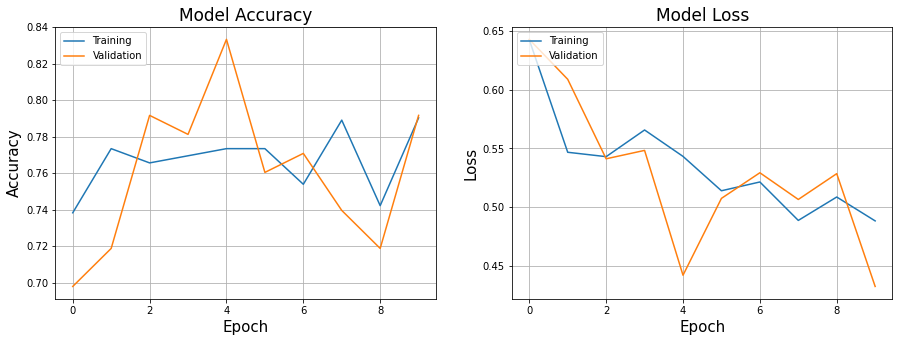

In [ ]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['accuracy']
y2 = history.history['val_accuracy']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
# plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
# plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()